In [10]:
import pandas as pd
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [36]:
# 데이터 불러오기
train_data = pd.read_csv("~/project/MIMIC-III/Data/FINAL/Final Data_Split/train_data(1%)_down.csv")
test_data = pd.read_csv("~/project/MIMIC-III/Data/FINAL/Final Data_Split/test_data(1%)_down.csv")

train_data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS", "ETHNICITY"], axis=1, inplace=True)
test_data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS", "ETHNICITY"], axis=1, inplace=True)

train_data = pd.get_dummies(train_data, columns=["GENDER"])
test_data = pd.get_dummies(test_data, columns=["GENDER"])

In [37]:
# train_data와 test_data의 칼럼을 맞추기 위해 차집합을 계산
missing_columns_in_test = set(train_data.columns) - set(test_data.columns)
missing_columns_in_train = set(test_data.columns) - set(train_data.columns)

# test_data에 train_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_test:
    test_data[col] = 0

# train_data에 test_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_train:
    train_data[col] = 0
    
####################################################################
# Down Sampling
# train 데이터의 레이블 비율 확인
# train_labels = train_data['y']
# label_counts = train_labels.value_counts()

# # train 데이터의 레이블 비율이 1:1이 되도록 분할
# class_0_data = train_data[train_data['y'] == 0]
# class_1_data = train_data[train_data['y'] == 1]

# # 레이블이 0인 데이터 중에서 샘플 개수가 적은 만큼만 선택
# num_samples = min(label_counts[0], label_counts[1])
# class_0_data = class_0_data.sample(num_samples, random_state=42)

# # 레이블이 1인 데이터 중에서 샘플 개수가 적은 만큼만 선택
# class_1_data = class_1_data.sample(num_samples, random_state=42)

# # 선택한 데이터를 결합하여 최종 train 데이터 생성
# train_data = pd.concat([class_0_data, class_1_data])
####################################################################


# Features와 Target 설정
X_train = train_data.drop('y', axis=1)
y_train = train_data['y']
X_test = test_data.drop('y', axis=1)

print("train shape\n",X_train.shape,"\n")
print("train shape\n",X_test.shape,"\n")

target = "y"
features = [f for f in train_data.columns if f not in [target]]

print("train value\n",train_data['y'].value_counts())
print("test value\n",test_data['y'].value_counts())

train shape
 (978, 67) 

train shape
 (457, 67) 

train value
 0    489
1    489
Name: y, dtype: int64
test value
 0    341
1    116
Name: y, dtype: int64


In [38]:
# 로지스틱 회귀 모델 학습
def objective(trial):
    c = trial.suggest_float("c", 1e-8, 10.0, log=True)
    
    model = LogisticRegression(C=c, random_state=42)
    
    # Cross Validation을 통한 평가 지표 계산
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    return scores.mean()



In [39]:
from sklearn.metrics import roc_auc_score

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
y_pred_list = []
model_list = []
auroc_list = []

for _ in range(10):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=30, gc_after_trial=True)

    # 최적 하이퍼파라미터 확인
    best_c = study.best_params["c"]

    # 최적 모델 학습 및 평가
    best_model = LogisticRegression(C=best_c, random_state=42)
    best_model.fit(X_train, y_train)

    # Test 데이터로 모델 평가
    y_pred = best_model.predict(X_test)
    y_score = best_model.predict_proba(X_test)

    accuracy = accuracy_score(test_data['y'], y_pred)
    precision = precision_score(test_data['y'], y_pred)
    recall = recall_score(test_data['y'], y_pred)
    f1 = f1_score(test_data['y'], y_pred)
    auroc = roc_auc_score(test_data['y'], y_score[:,1])

    rounded_accuracy = round(accuracy * 100, 2)
    rounded_precision = round(precision * 100, 2)
    rounded_recall = round(recall * 100, 2)
    rounded_f1 = round(f1 * 100, 2)
    rounded_auroc = round(auroc * 100, 2)
    
    accuracy_list.append(rounded_accuracy)
    precision_list.append(rounded_precision)
    recall_list.append(rounded_recall)
    f1_list.append(rounded_f1)
    y_pred_list.append(y_pred)
    auroc_list.append(rounded_auroc)

    print("Test Accuracy:", rounded_accuracy)
    print("Precision:", rounded_precision)
    print("Recall:", rounded_recall)
    print("F1-score:", rounded_f1)
    print("AUROC:", rounded_auroc)

[I 2023-10-02 14:25:02,143] A new study created in memory with name: no-name-6e3f20f3-cafd-49f1-b6f8-dfed90997ba3
[I 2023-10-02 14:25:02,284] Trial 0 finished with value: 0.6335203264493743 and parameters: {'c': 0.336290633167195}. Best is trial 0 with value: 0.6335203264493743.
[I 2023-10-02 14:25:02,395] Trial 1 finished with value: 0.5139845626721615 and parameters: {'c': 2.3811902963093945e-08}. Best is trial 0 with value: 0.6335203264493743.
[I 2023-10-02 14:25:02,594] Trial 2 finished with value: 0.6345331044591943 and parameters: {'c': 3.273497328156912}. Best is trial 2 with value: 0.6345331044591943.
[I 2023-10-02 14:25:02,785] Trial 3 finished with value: 0.6337890350508455 and parameters: {'c': 0.00021361689645615713}. Best is trial 2 with value: 0.6345331044591943.
[I 2023-10-02 14:25:03,018] Trial 4 finished with value: 0.6345373986174245 and parameters: {'c': 0.20926325717551036}. Best is trial 4 with value: 0.6345373986174245.
[I 2023-10-02 14:25:03,235] Trial 5 finished

Test Accuracy: 64.33
Precision: 38.65
Recall: 68.97
F1-score: 49.54
AUROC: 71.87


[I 2023-10-02 14:25:08,427] Trial 2 finished with value: 0.6397448498813395 and parameters: {'c': 0.15553098380090324}. Best is trial 2 with value: 0.6397448498813395.
[I 2023-10-02 14:25:08,634] Trial 3 finished with value: 0.6354245167164517 and parameters: {'c': 0.14484588587626424}. Best is trial 2 with value: 0.6397448498813395.
[I 2023-10-02 14:25:08,737] Trial 4 finished with value: 0.546922073966573 and parameters: {'c': 4.561530763768037e-08}. Best is trial 2 with value: 0.6397448498813395.
[I 2023-10-02 14:25:08,934] Trial 5 finished with value: 0.6264015607235466 and parameters: {'c': 9.018781072132342e-05}. Best is trial 2 with value: 0.6397448498813395.
[I 2023-10-02 14:25:09,131] Trial 6 finished with value: 0.6339626705189428 and parameters: {'c': 0.000576156156072912}. Best is trial 2 with value: 0.6397448498813395.
[I 2023-10-02 14:25:09,427] Trial 7 finished with value: 0.6291014934445596 and parameters: {'c': 0.18569286387580491}. Best is trial 2 with value: 0.639744

Test Accuracy: 65.21
Precision: 38.86
Recall: 64.66
F1-score: 48.54
AUROC: 71.61


[I 2023-10-02 14:25:14,559] Trial 1 finished with value: 0.5654995338775206 and parameters: {'c': 7.016943799607513e-08}. Best is trial 0 with value: 0.6156466525155581.
[I 2023-10-02 14:25:14,755] Trial 2 finished with value: 0.6266821474258958 and parameters: {'c': 0.00010247423185633236}. Best is trial 2 with value: 0.6266821474258958.
[I 2023-10-02 14:25:14,954] Trial 3 finished with value: 0.6276090674355828 and parameters: {'c': 0.00018234614792350982}. Best is trial 3 with value: 0.6276090674355828.
[I 2023-10-02 14:25:15,148] Trial 4 finished with value: 0.6230158586624104 and parameters: {'c': 0.0665612280835251}. Best is trial 3 with value: 0.6276090674355828.
[I 2023-10-02 14:25:15,402] Trial 5 finished with value: 0.6302002434301057 and parameters: {'c': 0.0030757977055167808}. Best is trial 5 with value: 0.6302002434301057.
[I 2023-10-02 14:25:15,652] Trial 6 finished with value: 0.633863218569822 and parameters: {'c': 0.05773878360411675}. Best is trial 6 with value: 0.63

Test Accuracy: 64.77
Precision: 38.92
Recall: 68.1
F1-score: 49.53
AUROC: 71.52


[I 2023-10-02 14:25:20,832] Trial 2 finished with value: 0.6310086726998492 and parameters: {'c': 0.2288352957273774}. Best is trial 2 with value: 0.6310086726998492.
[I 2023-10-02 14:25:21,038] Trial 3 finished with value: 0.6404910918272868 and parameters: {'c': 0.06593791280552717}. Best is trial 3 with value: 0.6404910918272868.
[I 2023-10-02 14:25:21,176] Trial 4 finished with value: 0.5865843630792998 and parameters: {'c': 2.580183420861324e-06}. Best is trial 3 with value: 0.6404910918272868.
[I 2023-10-02 14:25:21,309] Trial 5 finished with value: 0.5888088511543483 and parameters: {'c': 4.358344875409247e-06}. Best is trial 3 with value: 0.6404910918272868.
[I 2023-10-02 14:25:21,412] Trial 6 finished with value: 0.5502605980136773 and parameters: {'c': 5.202729639591683e-08}. Best is trial 3 with value: 0.6404910918272868.
[I 2023-10-02 14:25:21,612] Trial 7 finished with value: 0.6399295160694274 and parameters: {'c': 0.02746830520108892}. Best is trial 3 with value: 0.64049

Test Accuracy: 64.77
Precision: 38.69
Recall: 66.38
F1-score: 48.89
AUROC: 71.46


[I 2023-10-02 14:25:26,430] Trial 1 finished with value: 0.628408508022214 and parameters: {'c': 0.017934123871388517}. Best is trial 0 with value: 0.632593466342765.
[I 2023-10-02 14:25:26,540] Trial 2 finished with value: 0.5714034361802851 and parameters: {'c': 1.589591446251672e-07}. Best is trial 0 with value: 0.632593466342765.
[I 2023-10-02 14:25:26,667] Trial 3 finished with value: 0.5846827626541757 and parameters: {'c': 2.3537648441532246e-06}. Best is trial 0 with value: 0.632593466342765.
[I 2023-10-02 14:25:26,762] Trial 4 finished with value: 0.570768142939358 and parameters: {'c': 1.2974758383266597e-07}. Best is trial 0 with value: 0.632593466342765.
[I 2023-10-02 14:25:26,860] Trial 5 finished with value: 0.5635474153368717 and parameters: {'c': 6.34458918161983e-08}. Best is trial 0 with value: 0.632593466342765.
[I 2023-10-02 14:25:27,077] Trial 6 finished with value: 0.6274775067366529 and parameters: {'c': 0.0033690164190990383}. Best is trial 0 with value: 0.63259

Test Accuracy: 64.77
Precision: 38.81
Recall: 67.24
F1-score: 49.21
AUROC: 71.83


[I 2023-10-02 14:25:32,112] Trial 1 finished with value: 0.6521168290000239 and parameters: {'c': 1.4409242846115338}. Best is trial 1 with value: 0.6521168290000239.
[I 2023-10-02 14:25:32,311] Trial 2 finished with value: 0.6409434461659895 and parameters: {'c': 0.05247227449339252}. Best is trial 1 with value: 0.6521168290000239.
[I 2023-10-02 14:25:32,511] Trial 3 finished with value: 0.6273565404625511 and parameters: {'c': 7.180140063923703}. Best is trial 1 with value: 0.6521168290000239.
[I 2023-10-02 14:25:32,708] Trial 4 finished with value: 0.6309225826972978 and parameters: {'c': 0.00015052298969922665}. Best is trial 1 with value: 0.6521168290000239.
[I 2023-10-02 14:25:32,809] Trial 5 finished with value: 0.5107782776056073 and parameters: {'c': 2.1943498769159193e-08}. Best is trial 1 with value: 0.6521168290000239.
[I 2023-10-02 14:25:33,010] Trial 6 finished with value: 0.6267758003404508 and parameters: {'c': 0.175867022224849}. Best is trial 1 with value: 0.652116829

Test Accuracy: 64.77
Precision: 38.69
Recall: 66.38
F1-score: 48.89
AUROC: 71.79


[I 2023-10-02 14:25:38,053] Trial 2 finished with value: 0.6139658761085425 and parameters: {'c': 2.9859682354781358e-05}. Best is trial 2 with value: 0.6139658761085425.
[I 2023-10-02 14:25:38,165] Trial 3 finished with value: 0.5747393135545714 and parameters: {'c': 5.102857783857191e-07}. Best is trial 2 with value: 0.6139658761085425.
[I 2023-10-02 14:25:38,328] Trial 4 finished with value: 0.5939079823691079 and parameters: {'c': 4.650141816621122e-06}. Best is trial 2 with value: 0.6139658761085425.
[I 2023-10-02 14:25:38,597] Trial 5 finished with value: 0.642872956372815 and parameters: {'c': 0.004146723243072835}. Best is trial 5 with value: 0.642872956372815.
[I 2023-10-02 14:25:38,802] Trial 6 finished with value: 0.6327506386221 and parameters: {'c': 0.0023833091557107365}. Best is trial 5 with value: 0.642872956372815.
[I 2023-10-02 14:25:38,911] Trial 7 finished with value: 0.5692033562681883 and parameters: {'c': 1.2521694824552637e-07}. Best is trial 5 with value: 0.642

Test Accuracy: 64.55
Precision: 38.61
Recall: 67.24
F1-score: 49.06
AUROC: 71.95


[I 2023-10-02 14:25:43,819] Trial 1 finished with value: 0.5713285447368731 and parameters: {'c': 1.3576765478622413e-07}. Best is trial 0 with value: 0.629757479219084.
[I 2023-10-02 14:25:44,020] Trial 2 finished with value: 0.6328524806807223 and parameters: {'c': 0.4032655198091079}. Best is trial 2 with value: 0.6328524806807223.
[I 2023-10-02 14:25:44,221] Trial 3 finished with value: 0.6280479665990051 and parameters: {'c': 1.2770731493625365}. Best is trial 2 with value: 0.6328524806807223.
[I 2023-10-02 14:25:44,326] Trial 4 finished with value: 0.5692033562681883 and parameters: {'c': 1.2125618074264588e-07}. Best is trial 2 with value: 0.6328524806807223.
[I 2023-10-02 14:25:44,521] Trial 5 finished with value: 0.6414936706191493 and parameters: {'c': 4.158371825221771}. Best is trial 5 with value: 0.6414936706191493.
[I 2023-10-02 14:25:44,714] Trial 6 finished with value: 0.6270909554140012 and parameters: {'c': 1.5393069491966742}. Best is trial 5 with value: 0.6414936706

Test Accuracy: 64.55
Precision: 38.61
Recall: 67.24
F1-score: 49.06
AUROC: 71.81


[I 2023-10-02 14:25:49,898] Trial 1 finished with value: 0.6262567062567064 and parameters: {'c': 8.687654393010742e-05}. Best is trial 0 with value: 0.6324265219756827.
[I 2023-10-02 14:25:50,097] Trial 2 finished with value: 0.6282247015438684 and parameters: {'c': 0.0005358224141393765}. Best is trial 0 with value: 0.6324265219756827.
[I 2023-10-02 14:25:50,215] Trial 3 finished with value: 0.5963517816511906 and parameters: {'c': 1.0486472566671817e-06}. Best is trial 0 with value: 0.6324265219756827.
[I 2023-10-02 14:25:50,318] Trial 4 finished with value: 0.5413407575043678 and parameters: {'c': 4.307529850343238e-08}. Best is trial 0 with value: 0.6324265219756827.
[I 2023-10-02 14:25:50,540] Trial 5 finished with value: 0.6382781897256502 and parameters: {'c': 0.8660085644356336}. Best is trial 5 with value: 0.6382781897256502.
[I 2023-10-02 14:25:50,773] Trial 6 finished with value: 0.6314815750117846 and parameters: {'c': 0.0001643984166777676}. Best is trial 5 with value: 0.

Test Accuracy: 64.55
Precision: 38.5
Recall: 66.38
F1-score: 48.73
AUROC: 71.44


[I 2023-10-02 14:25:55,998] Trial 1 finished with value: 0.6393128213447812 and parameters: {'c': 0.42624542180025976}. Best is trial 1 with value: 0.6393128213447812.
[I 2023-10-02 14:25:56,133] Trial 2 finished with value: 0.59286838473644 and parameters: {'c': 2.7809741642249487e-06}. Best is trial 1 with value: 0.6393128213447812.
[I 2023-10-02 14:25:56,336] Trial 3 finished with value: 0.6431343996706591 and parameters: {'c': 0.05596223087791887}. Best is trial 3 with value: 0.6431343996706591.
[I 2023-10-02 14:25:56,489] Trial 4 finished with value: 0.6077173768885353 and parameters: {'c': 7.633828239391155e-06}. Best is trial 3 with value: 0.6431343996706591.
[I 2023-10-02 14:25:56,686] Trial 5 finished with value: 0.6349361989718558 and parameters: {'c': 3.44923401615738}. Best is trial 3 with value: 0.6431343996706591.
[I 2023-10-02 14:25:56,891] Trial 6 finished with value: 0.6427418306406056 and parameters: {'c': 0.0032787847062877816}. Best is trial 3 with value: 0.64313439

Test Accuracy: 63.89
Precision: 38.05
Recall: 67.24
F1-score: 48.6
AUROC: 71.59


In [40]:

data = {
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list,
    'AUROC':auroc_list,
    'Predictions': y_pred_list
    
}

# 딕셔너리를 DataFrame으로 변환
df = pd.DataFrame(data)
df

,Accuracy,Precision,Recall,F1 Score,AUROC,Predictions
0,64.33,38.65,68.97,49.54,71.87,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, ..."
1,65.21,38.86,64.66,48.54,71.61,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, ..."
2,64.77,38.92,68.10,49.53,71.52,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, ..."
3,64.77,38.69,66.38,48.89,71.46,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, ..."
4,64.77,38.81,67.24,49.21,71.83,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, ..."
5,64.77,38.69,66.38,48.89,71.79,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ..."
6,64.55,38.61,67.24,49.06,71.95,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ..."
7,64.55,38.61,67.24,49.06,71.81,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ..."
8,64.55,38.50,66.38,48.73,71.44,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, ..."
9,63.89,38.05,67.24,48.60,71.59,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ..."


### DataFrame을 CSV 파일로 저장

In [41]:
df.to_csv('~/project/MIMIC-III/Model/Output/Logistic Regression/LR(1%).csv', index=False)  # index를 저장하지 않으려면 index=False로 설정

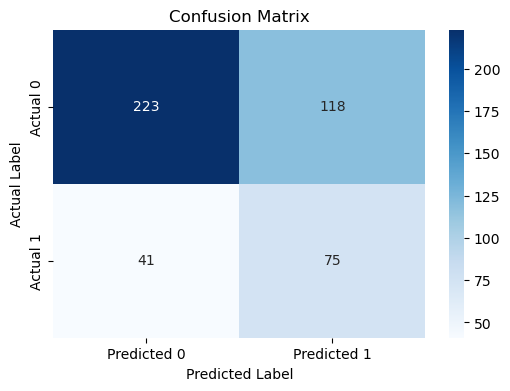

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.63      0.72       341
           1       0.38      0.67      0.49       116

    accuracy                           0.64       457
   macro avg       0.61      0.65      0.60       457
weighted avg       0.73      0.64      0.66       457



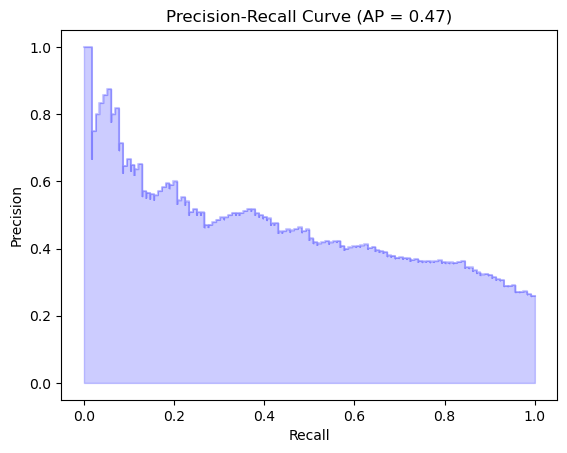

In [42]:
# 그리고 싶은 confusion matrix index
idx = 1 

cm = confusion_matrix(test_data['y'], y_pred_list[idx])

# Confusion Matrix 시각화
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

# Classification Report 출력
print("Classification Report:")
print(classification_report(test_data['y'], y_pred))

# Precision-Recall Curve 계산 및 시각화
precision, recall, _ = precision_recall_curve(test_data['y'], best_model.predict_proba(X_test)[:, 1])
average_precision = auc(recall, precision)
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.show()
